# PROYECTO - CARS - DSA

In [1]:
# Importación librerías
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import math

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('datos/dataTrain_carListings.csv')
dataTesting = pd.read_csv('datos/dataTest_carListings.csv', index_col=0)
data = dataTraining
test = dataTesting

## Análisis Exploratorio de Datos

In [3]:
# Visualización datos de entrenamiento
data.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [4]:
categorical_cols=data.select_dtypes(include=['object']).columns
categorical_cols

Index(['State', 'Make', 'Model'], dtype='object')

In [5]:
numerical_cols=data.select_dtypes(exclude=['object']).columns
numerical_cols

Index(['Price', 'Year', 'Mileage'], dtype='object')

In [6]:
data.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [12]:
df=pd.DataFrame(data['Make'].value_counts()).reset_index().rename(columns={'index':'make'})
df

,Make,count
0,Ford,62899
1,Chevrolet,58383
2,Toyota,45941
3,Honda,33191
4,Jeep,24369
5,GMC,20834
6,Kia,16352
7,Dodge,16159
8,Hyundai,15057
9,Lexus,13664


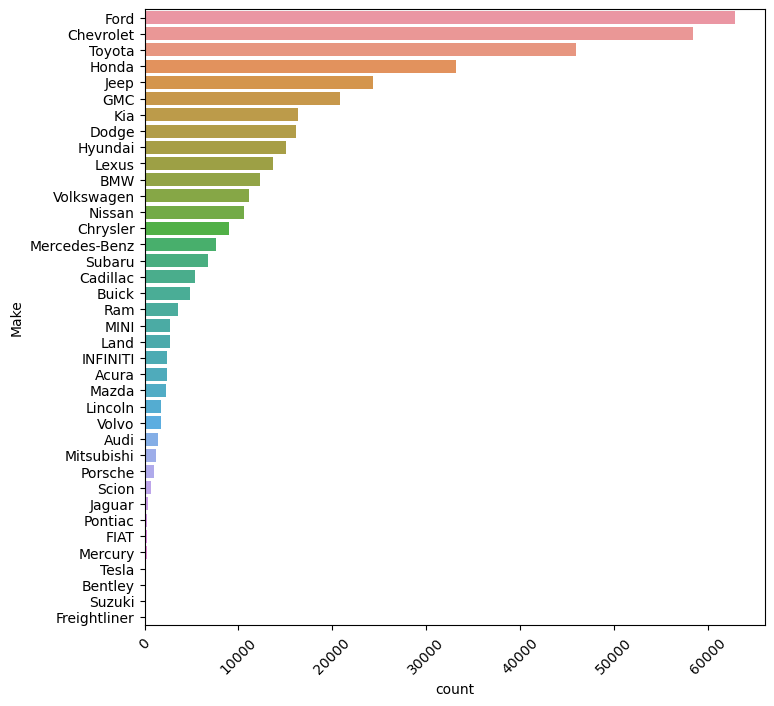

In [13]:
# Cantidad de carros por marca
plt.figure(figsize=(8,8))
plot = sns.barplot(y='Make',x='count',data=df)
plot=plt.setp(plot.get_xticklabels(), rotation=45)

In [15]:
df2=pd.DataFrame(data['State'].value_counts()).reset_index().rename(columns={'index':'state'})

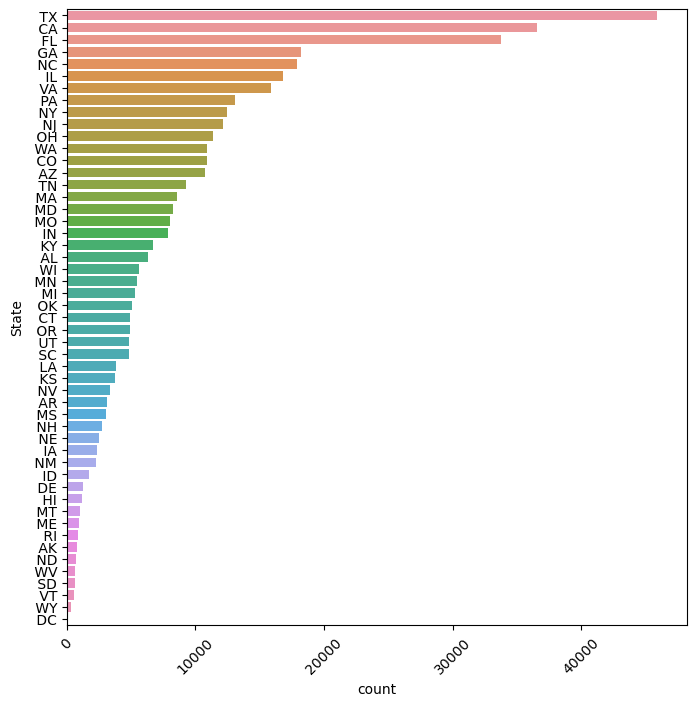

In [16]:
# Cantidad de vehículos por state
plt.figure(figsize=(8,8))
plot = sns.barplot(y='State',x='count',data=df2)
plot=plt.setp(plot.get_xticklabels(), rotation=45)